# Exploratory Data Analysis

**Author:** Joanna Khek Cuina   
**Date:** 2 June 2022

In [127]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Dates
from dateutil import parser
import isodate
import calendar
from datetime import date

# Model
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl


# 1. Project Description

![logo](images/beatemups.png)

In this project, I will be analysing one of my favourite youtube channel *BeatEmUps*. I have been following this channel for a really long time and I have to say that *Wood Hawker* (content creater of this channel) is extremely creative. His videos never fail to put a smile on my face! 

I wanted to do an analysis of his channel to find out the following questions:  

- How many videos uploaded by year?
- When are the videos usually uploaded?
- Are there any correlation between number of views, likes and comments?
- What are the best performing videos?
- What are the worst performing videos?

# 2. Getting the data

I managed to obtain the data using the Youtube API. The script can be found in `youtube-api.py`.

In [128]:
data = pd.read_csv("data.csv", index_col=0)

# 3. Data preprocessing

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 809 entries, 0 to 808
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       809 non-null    object
 1   title          809 non-null    object
 2   description    809 non-null    object
 3   publishedAt    809 non-null    object
 4   tags           808 non-null    object
 5   viewCount      809 non-null    int64 
 6   likeCount      809 non-null    int64 
 7   favoriteCount  809 non-null    int64 
 8   commentCount   809 non-null    int64 
 9   duration       809 non-null    object
 10  definition     809 non-null    object
 11  caption        809 non-null    bool  
dtypes: bool(1), int64(4), object(7)
memory usage: 76.6+ KB


- I will first convert the `publishedAt` column into separate `publishedYear`, `publishedMonth`, `publishedDay` and `publishedTime` columns
- Next, I will convert the `duration` column into `durationSecs`
- I will create another column called `daysPassed` to calculate the number of days since the video was uploaded
- I will create columns called `likesRatio` and `commentsRatio` to reflect the number of likes and comments on average for every 1000 views.

In [130]:
# Convert publishedAt column, which is in ISO 8601 format, into datetime
data["publishedAt"] = data["publishedAt"].apply(lambda x: parser.parse(x))
data["publishedDate"] = data["publishedAt"].apply(lambda x: x.strftime("%Y-%m-%d"))
data["publishedYear"] = data["publishedAt"].apply(lambda x: x.strftime("%Y"))
data["publishedMonth"] = data["publishedAt"].apply(lambda x: x.strftime("%m"))
data["publishedDay"] = data["publishedAt"].apply(lambda x: x.strftime("%A"))
data["publishedTime"] = data["publishedAt"].apply(lambda x: x.strftime("%H"))


In [131]:
# Convert duration column into durationSecs
data["durationSecs"] = data["duration"].apply(lambda x: isodate.parse_duration(x).total_seconds())

In [132]:
# Create daysPassed column
today = date.today()

data['publishedDate'] = pd.to_datetime(data['publishedDate'])
data['publishedDate'] = data['publishedDate'].apply(lambda x: x.date())

data["daysPassed"] = data['publishedDate'].apply(lambda x: abs(today - x).days)


In [133]:
def ratio(data, column):
    output = data[column]/data['viewCount']*1000
    return output

In [134]:
data["likeRatio"] = ratio(data, "likeCount")
data["commentRatio"] = ratio(data, "commentCount")

In [135]:
# Remove the first character 0 if it is just one digit
data["publishedMonthName"] = data["publishedMonth"].apply(lambda x: x[-1] if x[0]=="0" else x)

# Convert month number to month name
data["publishedMonthName"] = data["publishedMonthName"].apply(lambda x: calendar.month_name[int(x)])


# 4. Exploratory Data Analysis

## 4.1 Configurations

In [136]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"xtick.labelsize":15,
                             "ytick.labelsize":15,
                             "axes.titlesize":20,
                             "axes.labelsize":15})
default_col = '#5499C7'
highlight_col = '#CB4335'

## 4.2 Descriptive

In [137]:
def highlight_top(ax, orientation):
    if orientation == "horizontal":
        patch_h = [patch.get_width() for patch in ax.patches]
    elif orientation == "vertical":
        patch_h = [patch.get_height() for patch in ax.patches]
    
    max_value = max(patch_h)
    
    # Check if there are more than 1 largest value
    idx_tallest = [i for i, j in enumerate(patch_h) if j == max_value]
        
    for idx in idx_tallest:
        ax.patches[idx].set_facecolor(highlight_col)

I will create a copy of the dataframe to play around with without harming the original dataset.

In [138]:
data_copy = data.copy()

In [139]:
# Keep only columns needed for exploration
columns = ['title', 'description', 'tags', 'viewCount', 'likeCount', 'commentCount', 'likeRatio', 'commentRatio', 'daysPassed', 'publishedDate','publishedYear', 'publishedMonthName', 'publishedDay', 'publishedTime', 'durationSecs']

In [140]:
data_copy = data_copy.loc[:,columns]

### How many videos were uploaded each year?

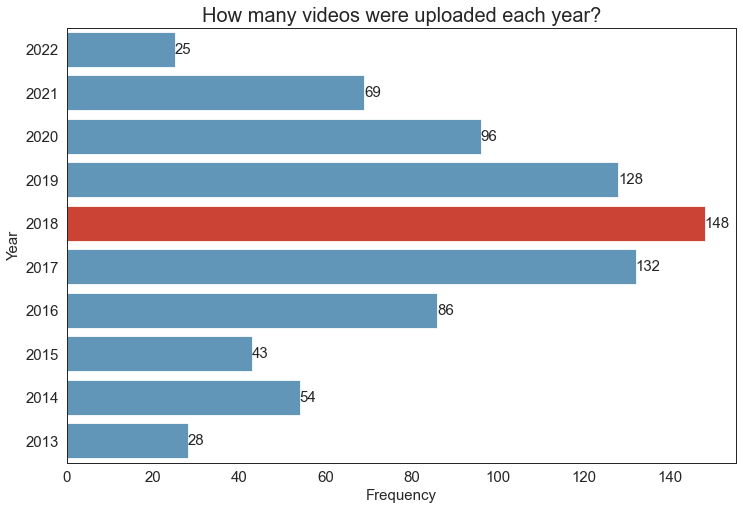

In [141]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y="publishedYear", data=data_copy, color=default_col)
ax.bar_label(ax.containers[0], fontsize=15)
highlight_top(ax, "horizontal")
plt.title("How many videos were uploaded each year?")
plt.xlabel("Frequency")
plt.ylabel("Year")
plt.show()

### When were the videos usually uploaded?

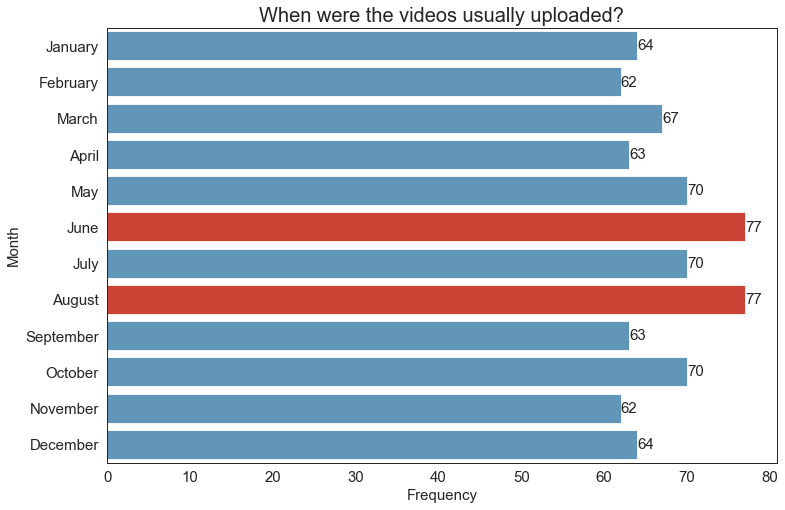

In [142]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y="publishedMonthName", data=data_copy, color=default_col,
                   order=['January','February','March','April','May','June','July','August','September','October','November','December'])
ax.bar_label(ax.containers[0], fontsize=15)
highlight_top(ax, "horizontal")
plt.title("When were the videos usually uploaded?")
plt.xlabel("Frequency")
plt.ylabel("Month")
plt.show()

The E3 Event (Electronic Entertainment Expo) was held every June so that might explain why June had more videos uploaded

### Which day were the videos usually uploaded?

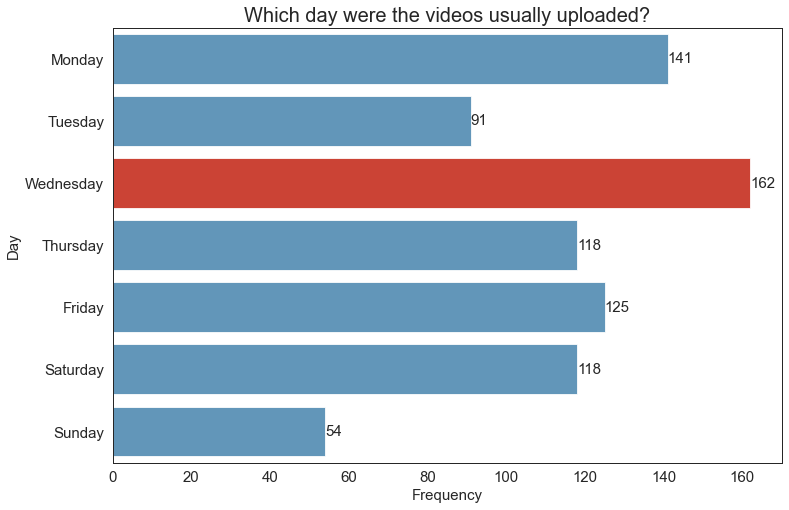

In [143]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y="publishedDay", data=data_copy, color=default_col, 
                   order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.bar_label(ax.containers[0], fontsize=15)
highlight_top(ax, "horizontal")
plt.title("Which day were the videos usually uploaded?")
plt.xlabel("Frequency")
plt.ylabel("Day")
plt.show()

### What time were the videos usually uploaded?

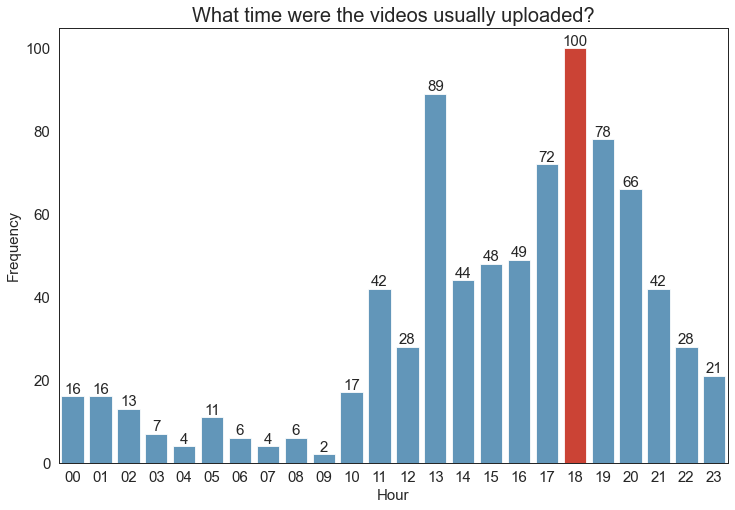

In [144]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x="publishedTime", data=data_copy, color=default_col,
                   order=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19',
                          '20','21','22','23'])
ax.bar_label(ax.containers[0], fontsize=15)
highlight_top(ax, "vertical")
plt.title("What time were the videos usually uploaded?")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.show()


Let's further categorise the time published into morning, afternoon, evening, night, midnight

In [145]:
def time_category(x):
    
    morning = ['06','07','08','09','10','11']
    afternoon = ['12','13','14','15','16']
    evening = ['17','18','19']
    night = ['20','21','22','23']
    midnight = ['00','01','02','03','04','05']
    
    if x in morning:
        cat = "Morning"
    elif x in afternoon:
        cat = "Afternoon"
    elif x in evening:
        cat = "Evening"
    elif x in night:
        cat = "Night"
    elif x in midnight:
        cat = "Midnight"
    return cat

In [146]:
data_copy["publishedTimeCat"] = data_copy["publishedTime"].apply(time_category)

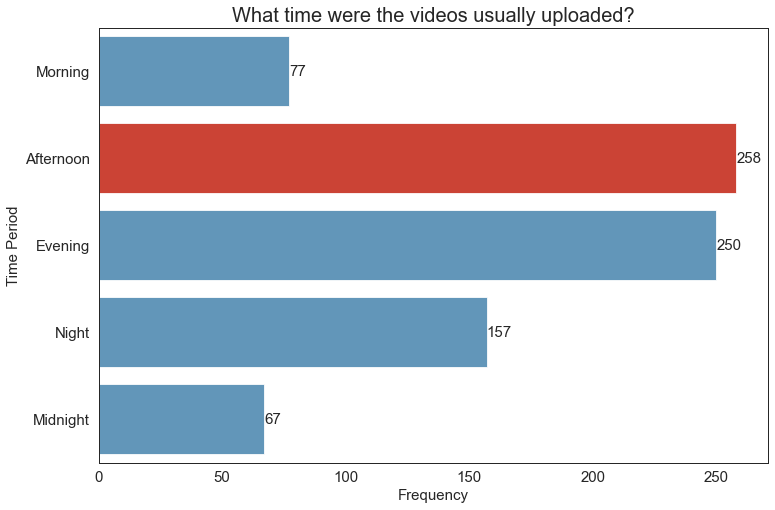

In [147]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y="publishedTimeCat", data=data_copy, color=default_col, 
                   order=['Morning','Afternoon','Evening','Night','Midnight'])
ax.bar_label(ax.containers[0], fontsize=15)
highlight_top(ax, "horizontal")
plt.title("What time were the videos usually uploaded?")
plt.xlabel("Frequency")
plt.ylabel("Time Period")
plt.show()

Most of the videos were uploaded around afternoon and evening period

### How long were the videos typically?

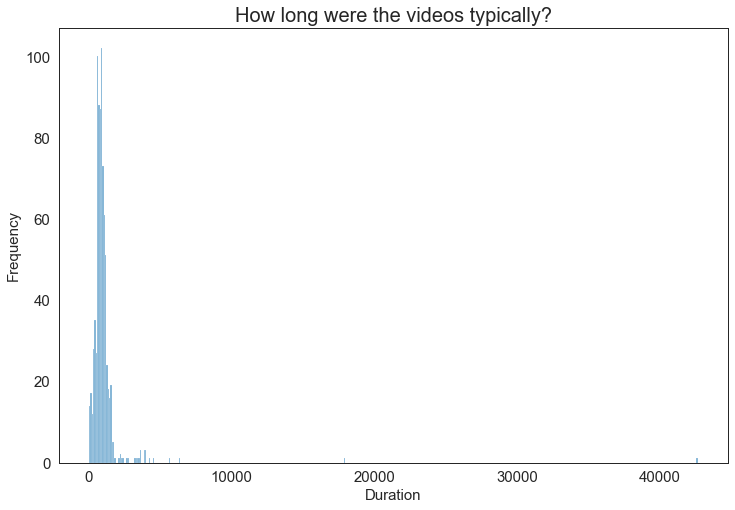

In [148]:
plt.figure(figsize=(12,8))
ax = sns.histplot(x="durationSecs",data=data_copy, color=default_col)
#ax.bar_label(ax.containers[0], fontsize=15)
#highlight_top(ax, "vertical")
plt.title("How long were the videos typically?")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.show()

There seems to be 2 outliers here. Let's take a closer look.

In [149]:
data_copy["durationSecs"].describe()

count      809.000000
mean      1008.021014
std       1691.332808
min         27.000000
25%        651.000000
50%        864.000000
75%       1087.000000
max      42656.000000
Name: durationSecs, dtype: float64

In [150]:
outliers = data_copy[data_copy["durationSecs"] > 10000].loc[:,["title","description","tags"]]

In [151]:
for i in range(0, len(outliers)):
    print("====== Tags {} ======".format(i))
    print(outliers["title"].values[i])
    print(outliers["tags"].values[i])

====== Tags 0 ======
Depression & Anxiety - Raising Awareness and Funds.
['beatemups', 'switch games', 'upcoming switch games', 'upcoming nintendo games', 'switch games coming soon', 'worth the price', 'nintendo switch', 'best switch games', 'worst switch games', 'good nintendo switch games', 'best nintendo switch games', 'nintendo', 'switch', 'nintendo direct', 'direct', '2018', 'nintendo direct 2018', 'live direct', 'live nintendo direct', 'nintendo event', 'Depression', 'Depression & Anxiety - Raising Awareness and Funds.']
====== Tags 1 ======
5 YEAR - 5 HOUR PARTY LIVE STREAM | PRIZES, SPIN WHEEL, Q&A, GAMEPLAY!
['5 year', 'gameplay', '5 years', '5 year anniversary', '5 years on youtube', 'best and worst', 'beatemups', 'The Best & Worst Of My Last 5 Years.', 'this is me beatemups', 'beatemups eshop', 'beatemups god of war', 'beatemups 5 years', 'beatemups reaction', 'game chasers', 'youtube', 'play button', 'anniversary', 'worst', 'best', 'cringe', 'eshop', 'nintendo', 'switch', '

The outliers were due to long live streaming.

## 4.3 Relationship with View Count

Here, we are going to look into patterns with the view count

### Is there a relationship between the likeCount/commentCount and viewCount?

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

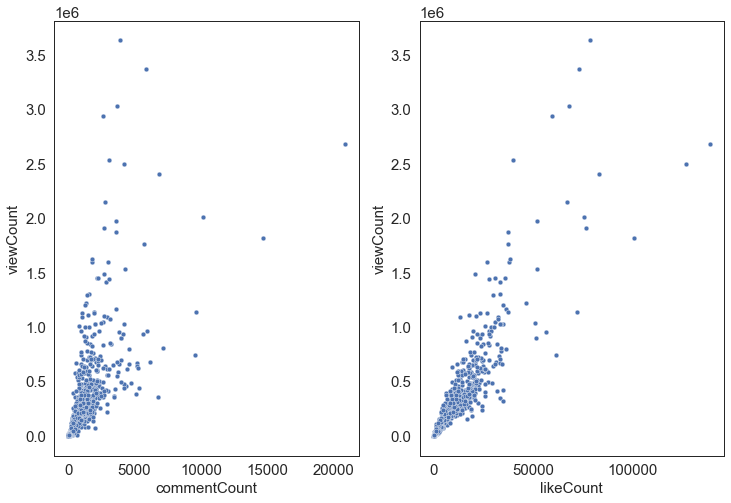

In [152]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(data=data_copy, x="commentCount", y="viewCount", ax=ax[0])
sns.scatterplot(data=data_copy, x="likeCount", y="viewCount", ax=ax[1])

Since more views will naturally draw more comments and likes. Instead, we can get the comment and like count per every 1000 views.

<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

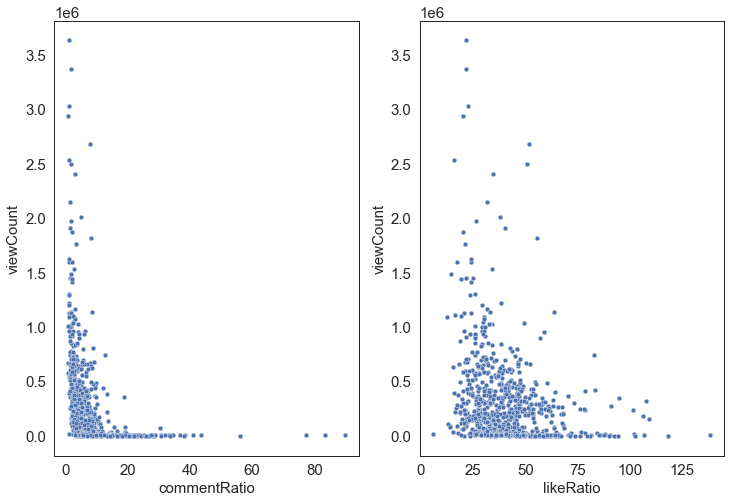

In [153]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
sns.scatterplot(data=data_copy, x="commentRatio", y="viewCount", ax=ax[0])
sns.scatterplot(data=data_copy, x="likeRatio", y="viewCount", ax=ax[1])

For every 1000 views, the relationship is less clear. There seems to be a positive relationship between likeCount and viewCount though its not too clear.

### Does longer videos lead to more views?

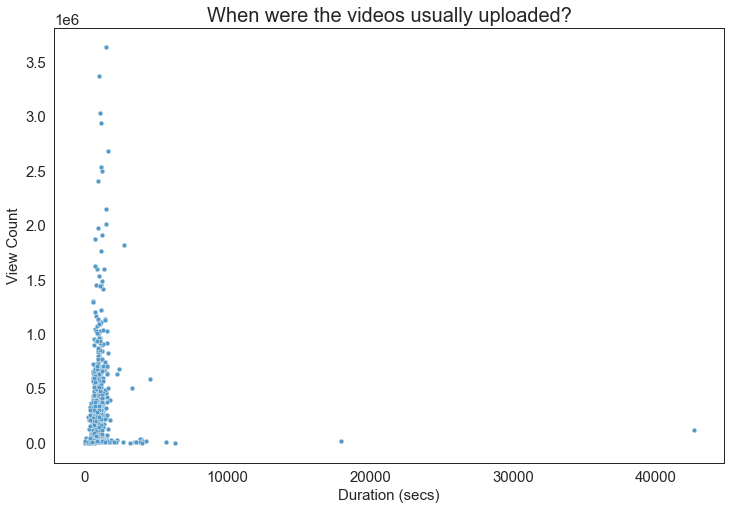

In [154]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="durationSecs", y="viewCount", data=data_copy, color=default_col)
plt.title("Does longer videos lead to more views?")
plt.xlabel("Duration (secs)")
plt.ylabel("View Count")
plt.show()

We have seen the two outliers earlier. Since those are livestreams and are not usually the kind of videos being uploaded, we will remove them to reflect a more accurate analysis. Let's remove those two points and plot the scatteplot again.

In [155]:
# Remove the two outliers
data_copy = data_copy[data_copy["durationSecs"] < 10000]

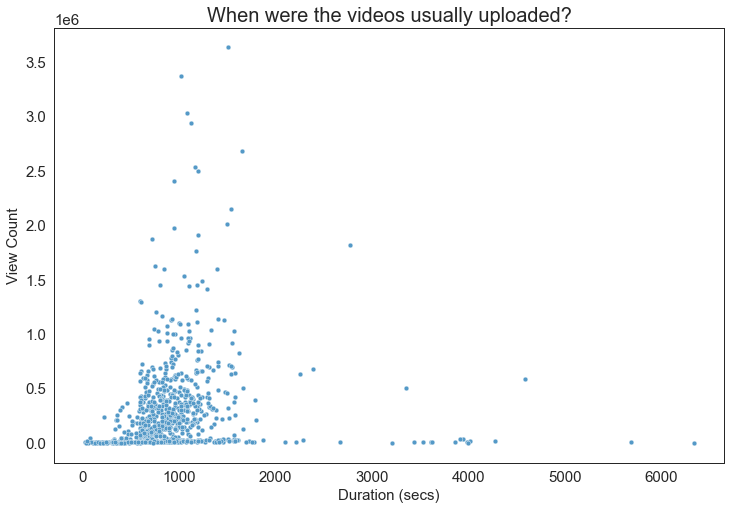

In [156]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="durationSecs", y="viewCount", data=data_copy, color=default_col)
plt.title("Does longer videos lead to more views?")
plt.xlabel("Duration (secs)")
plt.ylabel("View Count")
plt.show()

In general, there is a positive relationship between the duration and the view count with the exception of some videos.

### Videos that existed longer generally have more views/likes/comment?

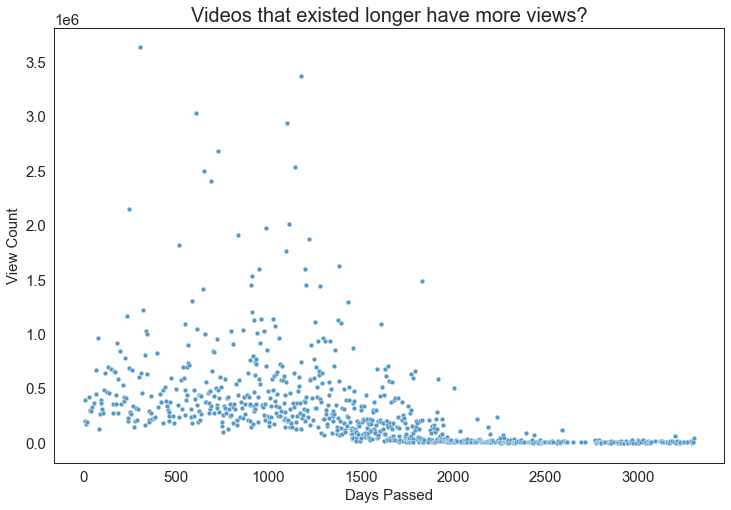

In [157]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="daysPassed", y="viewCount", data=data_copy, color=default_col)
plt.title("Videos that existed longer have more views?")
plt.xlabel("Days Passed")
plt.ylabel("View Count")
plt.show()

The assumption is not true as shown by the scatterplot. Some videos that have been uploaded for a long time did not get as many views. On the other hand, we have videos that were uploaded only less than 500 days ago reaching very high view count.

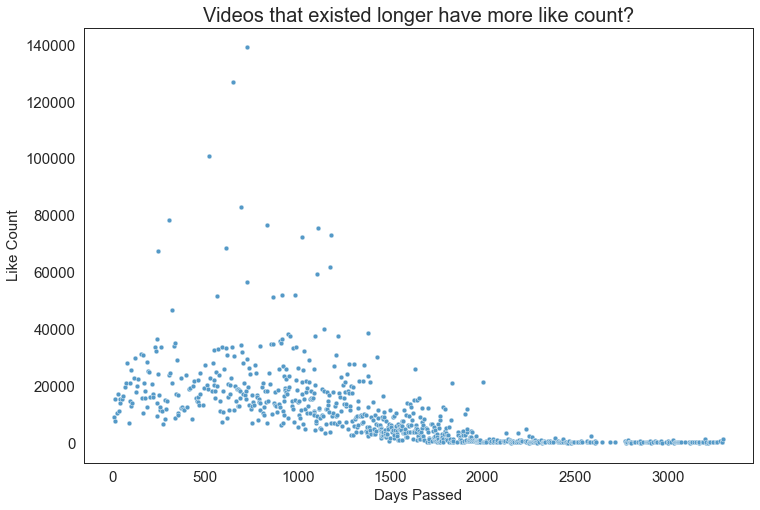

In [158]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="daysPassed", y="likeCount", data=data_copy, color=default_col)
plt.title("Videos that existed longer have more like count?")
plt.xlabel("Days Passed")
plt.ylabel("Like Count")
plt.show()

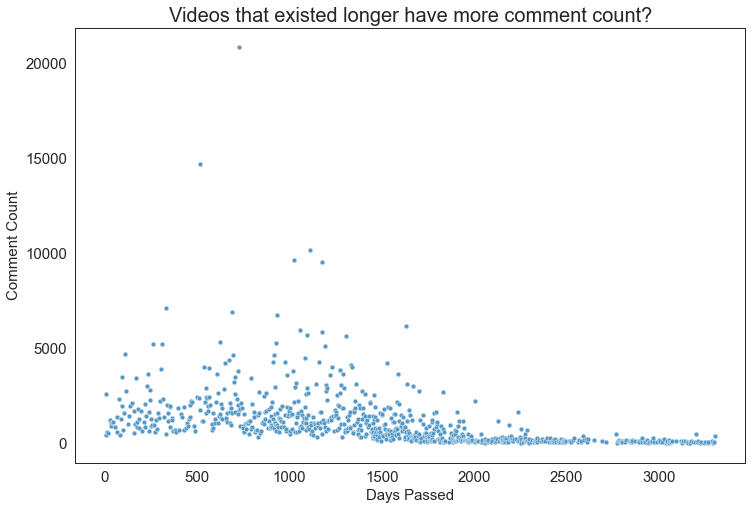

In [159]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="daysPassed", y="commentCount", data=data_copy, color=default_col)
plt.title("Videos that existed longer have more comment count?")
plt.xlabel("Days Passed")
plt.ylabel("Comment Count")
plt.show()

### 4.3 K-Means Clustering to identify well-performing videos

Let's try to identify videos that are performing well using viewCount, likeCount, commentCount and daysPassed through K-Means clustering analysis

In [160]:
len(data_copy) # After removing 2 outliers

807

In [161]:
data_copy_cluster = data_copy.loc[:,["viewCount", "likeCount", "commentCount", "daysPassed"]]

It is important to scale the input features before running K-Means or the clusters will be very stretched and K-Means will perform poorly.

In [162]:
# Standardization
scaler = StandardScaler()
cluster_scaler = scaler.fit_transform(data_copy_cluster)

We will find the best cluster k value using silhouette scores

In [163]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(cluster_scaler) for k in range(1,10)]

silhouette_scores = [silhouette_score(cluster_scaler, model.labels_) for model in kmeans_per_k[1:]]

c:\Users\joann\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


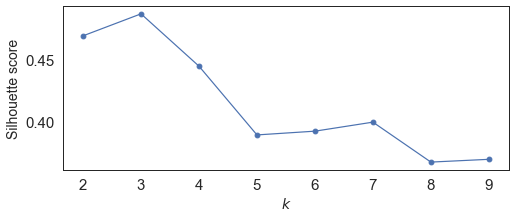

In [164]:
plt.figure(figsize=(8,3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

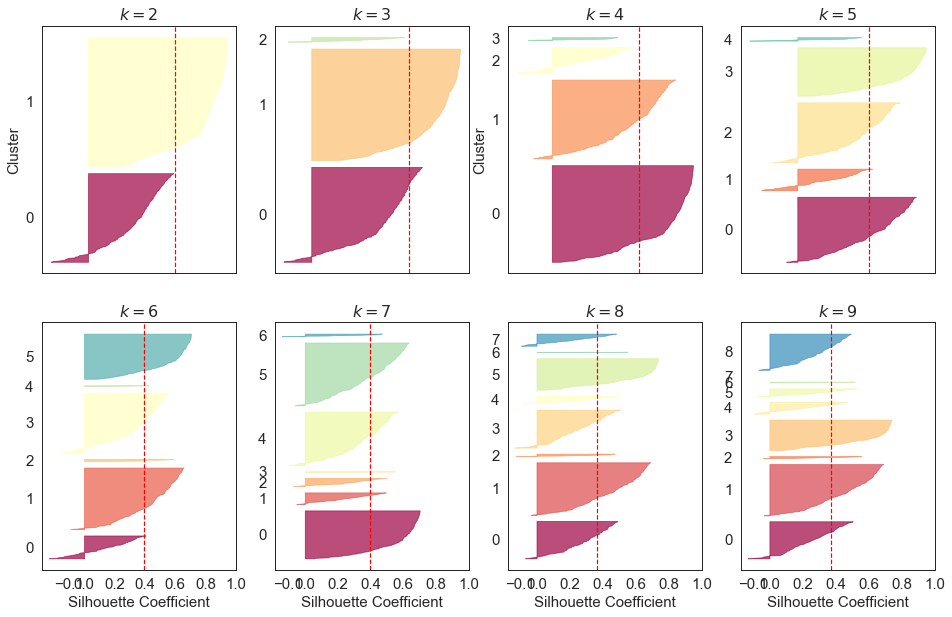

In [165]:
plt.figure(figsize=(16, 10))

for k in (2, 3, 4, 5, 6, 7, 8, 9):
    plt.subplot(2, 4, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(cluster_scaler, y_pred)

    padding = len(cluster_scaler) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (6,7,8,9):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

K=7 seems like a better cluster size since all of the cluster have higher silhouette score than the mean silhouette score for that cluster.

In [166]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
pred_cluster = kmeans.fit_predict(cluster_scaler)

In [167]:
data_copy["cluster"] = pred_cluster+1

Let's analyse the dataset by cluster

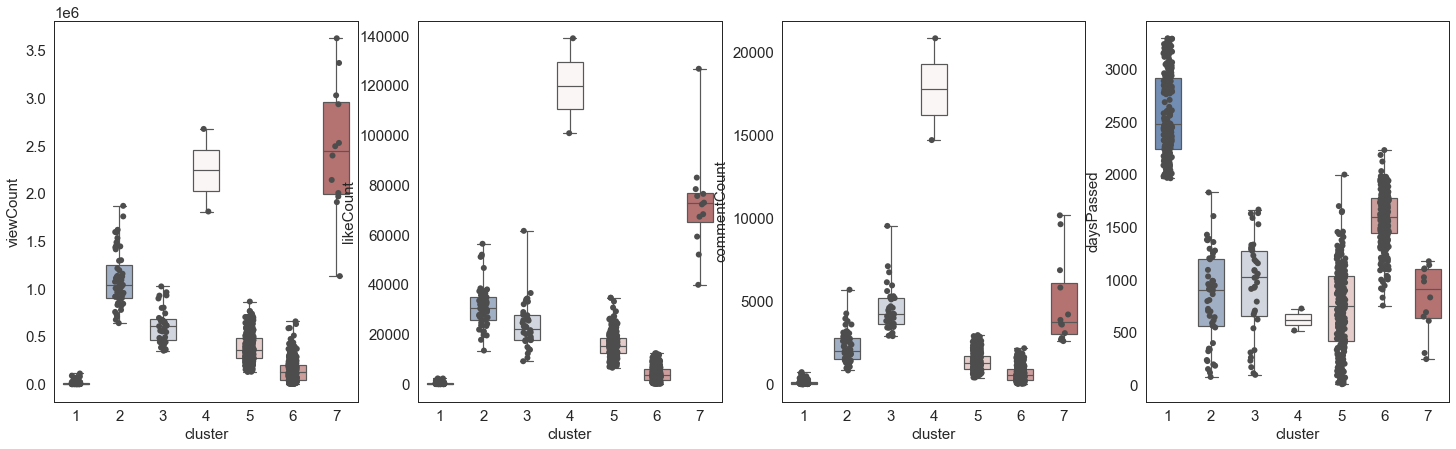

In [168]:
fig, ax = plt.subplots(1,4, figsize=(25,7))
sns.boxplot(x="cluster", y="viewCount", data=data_copy, whis=[0, 100], width=.6, palette="vlag", ax=ax[0])
sns.boxplot(x="cluster", y="likeCount", data=data_copy, whis=[0, 100], width=.6, palette="vlag", ax=ax[1])
sns.boxplot(x="cluster", y="commentCount", data=data_copy, whis=[0, 100], width=.6, palette="vlag", ax=ax[2])
sns.boxplot(x="cluster", y="daysPassed", data=data_copy, whis=[0, 100], width=.6, palette="vlag", ax=ax[3])
sns.stripplot(data=data_copy, x="cluster", y="viewCount", color=".3", size=6, linewidth=0, ax=ax[0])
sns.stripplot(data=data_copy, x="cluster", y="likeCount", color=".3", size=6, linewidth=0, ax=ax[1])
sns.stripplot(data=data_copy, x="cluster", y="commentCount", color=".3", size=6, linewidth=0, ax=ax[2])
sns.stripplot(data=data_copy, x="cluster", y="daysPassed", color=".3", size=6, linewidth=0, ax=ax[3])

plt.show()

From the boxplot, 
- videos cluster 4 seems to be performing really well due to the high viewCount, high likeCount, high commentCount and low daysPassed figures. 
- videos in cluster 7 performed well in terms of viewCount and likeCount but not so much in the commentCount.
- videos in cluster 1 performed poorly due to low viewCount, low likeCount, low commentCount and high daysPassed. This means that despite being uploaded to the channel a long time ago, these videos are still not drawing views, likes and comments.

#### Best performing videos (High views, high like count, high comment count)

Best performing videos came from cluster 4

In [169]:
data_copy[data_copy["cluster"] == 4].loc[:,["title", "description", "viewCount", "likeCount", "commentCount", "daysPassed"]]

,title,description,viewCount,likeCount,commentCount,daysPassed
94,Cyberpunk 2077: CD PROJEKT are all Liars,CD PROJEKT promised a lot for Cyberpunk 2077 b...,1812984,100893,14706,518
149,"I'll no longer be working with Nintendo, here'...",Nintendo contacted me and dropped me from thei...,2679453,139026,20834,727


#### Good performing videos (High views, high like count)

Good performing videos came from cluster 7

In [170]:
data_copy[data_copy["cluster"] == 7].loc[:,["title", "description", "viewCount", "likeCount", "commentCount", "daysPassed"]]

,title,description,viewCount,likeCount,commentCount,daysPassed
45,The WEIRD Nintendo Switch Accessories on Amazon,These WEIRD Nintendo Switch Accessories from A...,2144138,67336,2789,246
57,The FAKE $10 Nintendo Clone Consoles,Cheap Fake Nintendo Switch & Other Consoles //...,3630585,78433,3880,304
115,The FAKE $50 Nintendo Switch Consoles,Cheap Fake Nintendo Switch Consoles // SPONSOR...,3031868,68354,3647,610
126,10 Best FREE Games On Nintendo Switch!,Sponsored by VESSI: To experience the worlds f...,2498055,126779,4209,650
138,The 10 Nintendo Switch Games I Can't Live With...,These 10 Nintendo Switch Games AREN'T the BEST...,2400374,83047,6873,692
178,These FAKE Nintendo Switch Controllers BROKE M...,Go to http://buyraycon.com/beatemups for 15% o...,1911353,76516,2695,833
228,Is the NEW Nintendo Switch Lite ACTUALLY a Swi...,The NEW Nintendo Switch Lite AND The NEW Zelda...,1971166,52129,3600,985
241,My Girlfriend & I Buy WEIRD Nintendo Switch Ac...,"STRANGE, OBSCURE & WEIRD Nintendo Switch ACCES...",1135025,72306,9640,1025
272,My Girlfriend & I Buy WEIRD Nintendo Switch Ac...,Sponsored By SKILLSHARE - First 500 People Get...,2938470,59346,2605,1102
274,Dear Nintendo: THIS Is How You Make The Switch...,SPONSORED BY MANSCAPED! - 20% OFF Manscaped + ...,2007446,75666,10176,1109


#### Worst performing videos (Low views, low like, low comments count)

Worst performing videos came from cluster 1

In [171]:
data_copy[data_copy["cluster"] == 1].loc[:,["title", "description", "viewCount", "likeCount", "commentCount", "daysPassed"]]

,title,description,viewCount,likeCount,commentCount,daysPassed
593,What Is Youtube 'On The Rise'? Highlighting Up...,YouTube’s “On the Rise” initiative to highligh...,6549,284,72,1967
596,Is Paper Mario Color Splash Worth It?,Is Paper Mario Color Splash Worth Buying? Shou...,9816,421,108,1972
597,"I Move House, Again | Wood Vlogs",Moving House. I pack up my entire Video Game C...,12984,560,98,1974
600,Top 5 Nostalgic Christmas Movies,Christmas Movies that made our childhoods magi...,12631,315,76,1985
603,"Loot Gaming, Gimme What You Got. (It's Snowing...",http://www.lootcrate.com/beatemups USE THE COU...,3408,239,48,2003
...,...,...,...,...,...,...
804,The Legend Of Wood&Kane - 'Heart Break & Trium...,"We check out some local markets, hit up some g...",14866,602,79,3284
805,Wood&Kane - GameGrabs #2.5 (Feb-May Part 2),"Part 2, We bang out the rest of our pick ups!\...",2484,135,14,3293
806,Wood&Kane - Reply To Your Comments! #1,"4 Player Wii game reviews, mysterious lost foo...",4463,160,25,3294
807,Wood&Kane - GameGrabs #2 (Feb-May),PART 1!\nA very Resident Evil themed edition o...,4369,201,43,3295


#### On average, how is the channel growing over the years?

To see this, we divide the viewCount, likeCount, commentCount by the number of days passed and see on average per day how many view, likes and comments are the videos attracting.

In [172]:
data_copy["viewDays"] = data_copy["viewCount"]/data_copy["daysPassed"]
data_copy["likeDays"] = data_copy["likeCount"]/data_copy["daysPassed"]
data_copy["commentDays"] = data_copy["commentCount"]/data_copy["daysPassed"]

In [173]:
data_copy["publishedYear"] = data_copy["publishedYear"].apply(lambda x: int(x))

In [174]:
pd.DataFrame(data_copy.groupby("publishedYear").agg({"viewDays": "mean"}))

,viewDays
publishedYear,
2013,3.634676
2014,2.308366
2015,5.482595
2016,12.841456
2017,83.326106
2018,218.410324
2019,566.515966
2020,868.399244
2021,1842.454301


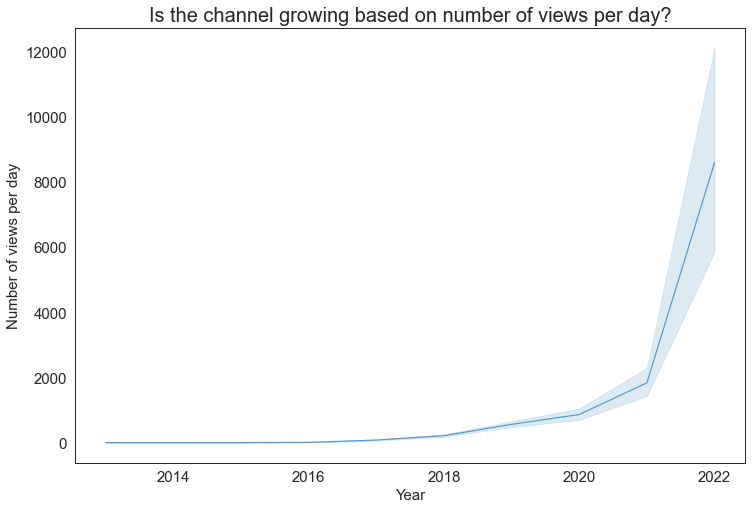

In [175]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x="publishedYear", y="viewDays", data=data_copy, color=default_col)
plt.title("Is the channel growing based on number of views per day?")
plt.xlabel("Year")
plt.ylabel("Number of views per day")
plt.show()

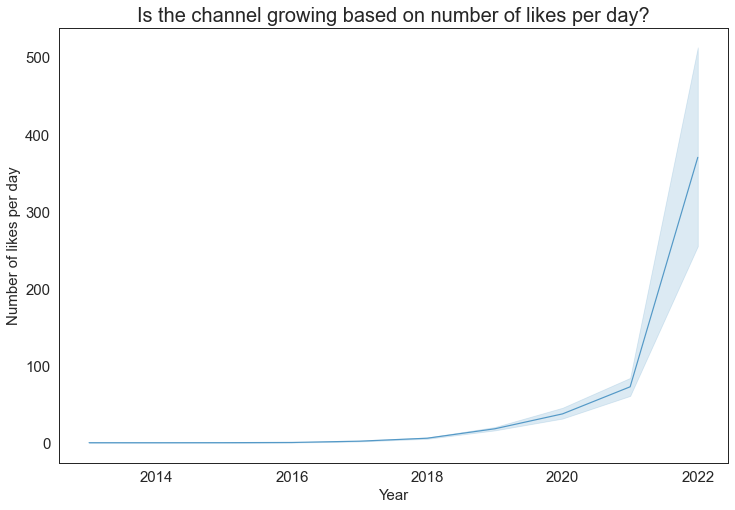

In [176]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x="publishedYear", y="likeDays", data=data_copy, color=default_col)
plt.title("Is the channel growing based on number of likes per day?")
plt.xlabel("Year")
plt.ylabel("Number of likes per day")
plt.show()

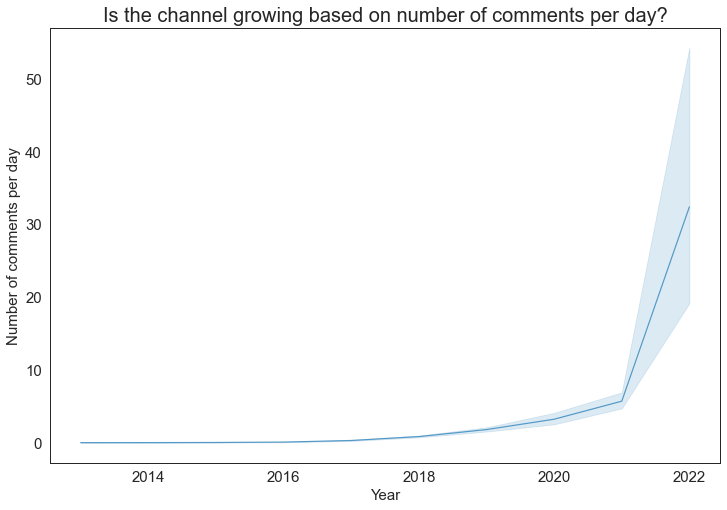

In [177]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(x="publishedYear", y="commentDays", data=data_copy, color=default_col)
plt.title("Is the channel growing based on number of comments per day?")
plt.xlabel("Year")
plt.ylabel("Number of comments per day")
plt.show()